# Libraries

In [2]:
import numpy as np
from omegaconf import OmegaConf
import models
import loss_func
import train
import loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import optimizer_Factory as of
import Data.genData as genData
import custom_plots as cp

# Load Data

Image shape: (500, 260)


<Figure size 640x480 with 0 Axes>

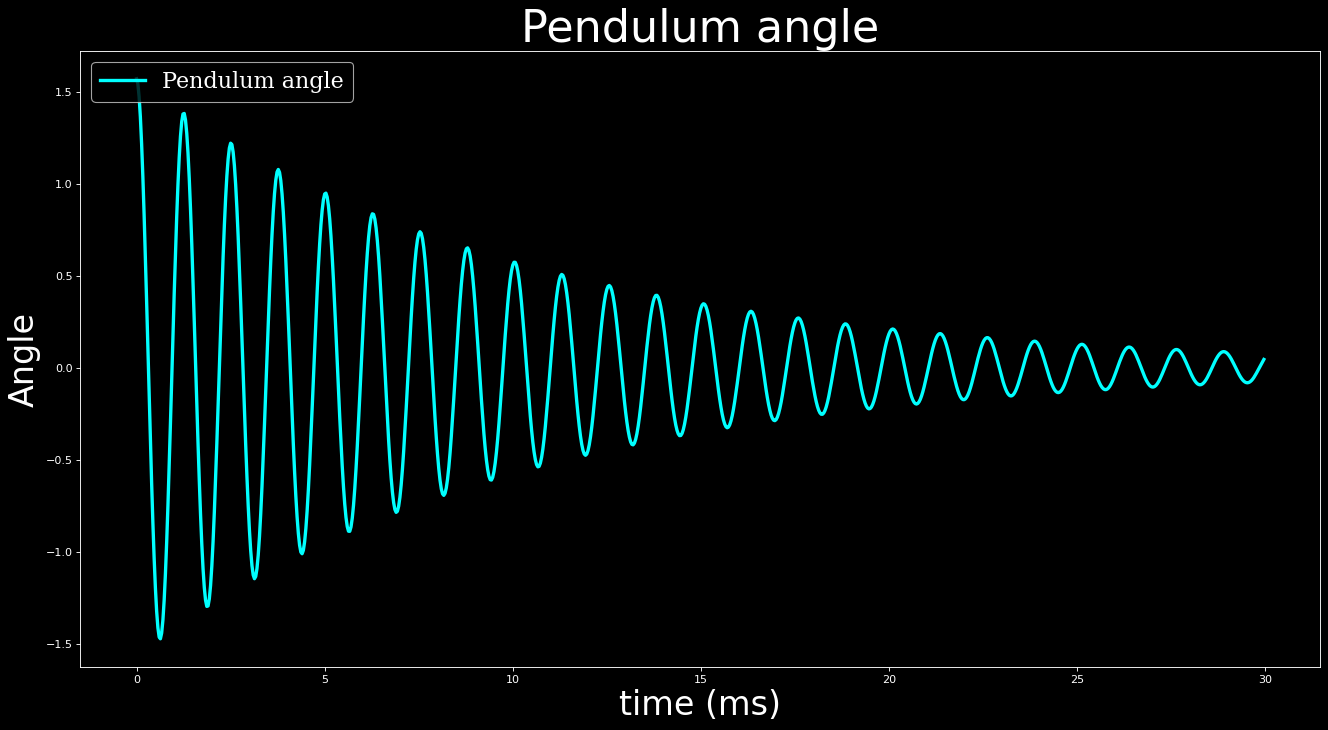

In [3]:
img = genData.create_pendulum_image(90)
print("Image shape:", img.size)
genData.generateVideo()

<Figure size 640x480 with 0 Axes>

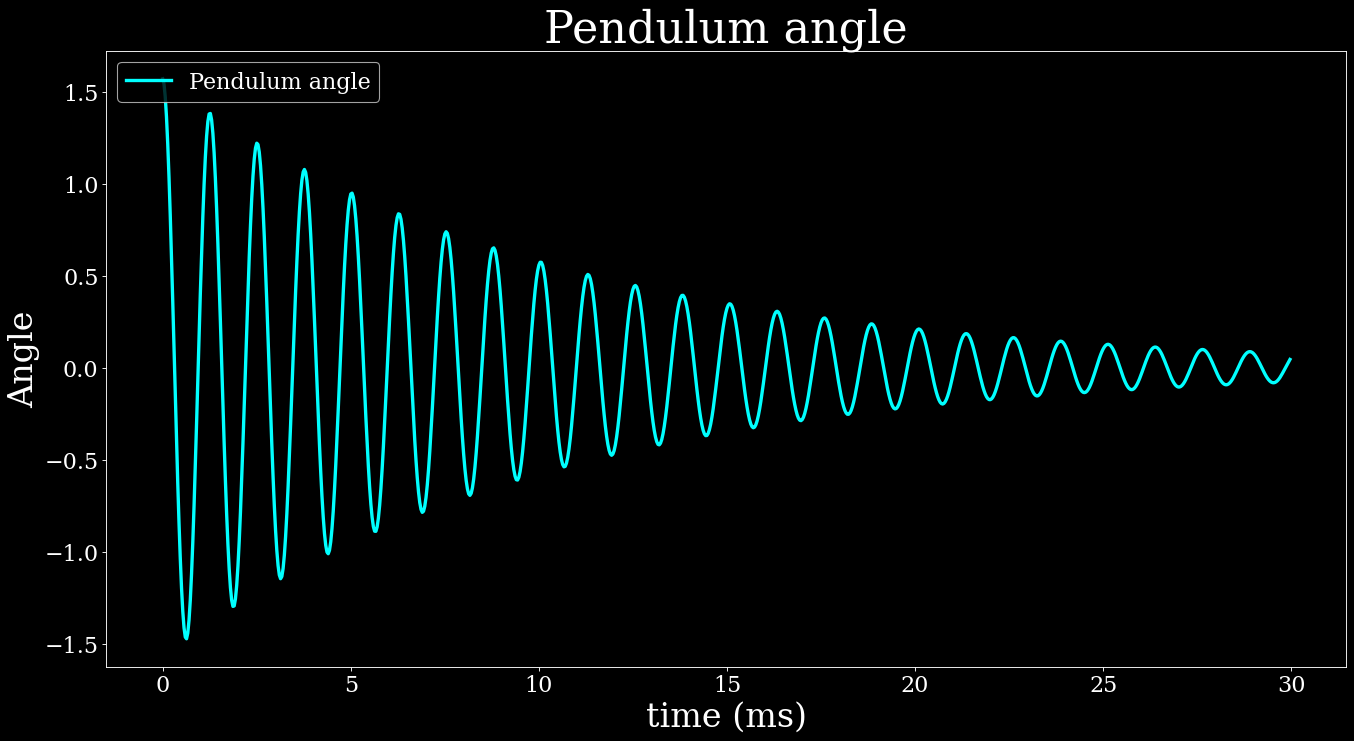

In [7]:
g=9.81
L=1
x0=np.pi/2
x1=np.pi/2.5
t,a = genData.generatePendulumA(g,L,x0, x1)

In [8]:

train_dataloader, test_dataloader, train_x, val_x  = loader.getLoader(a)

Batch shape: torch.Size([32, 1, 260, 500])


C:\Users\aleja\AppData\Local\Temp\ipykernel_41632\44959031.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r', 256)


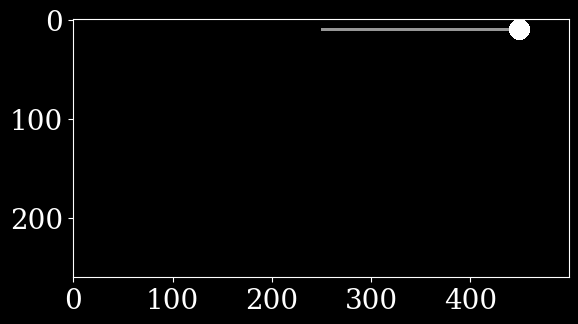

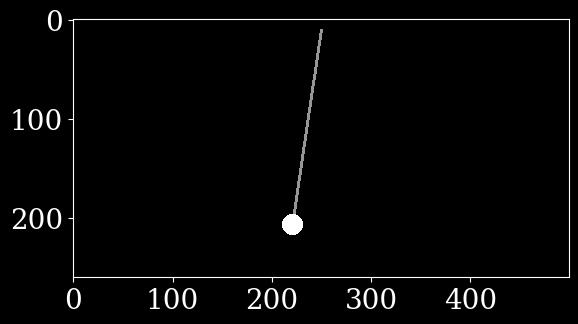

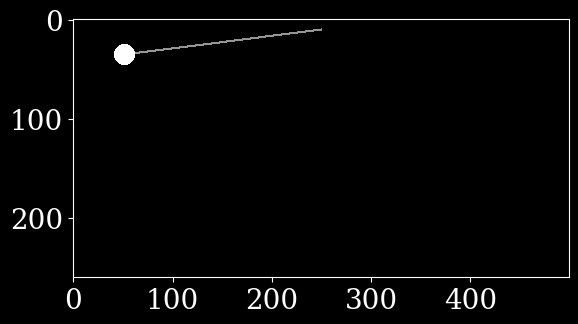

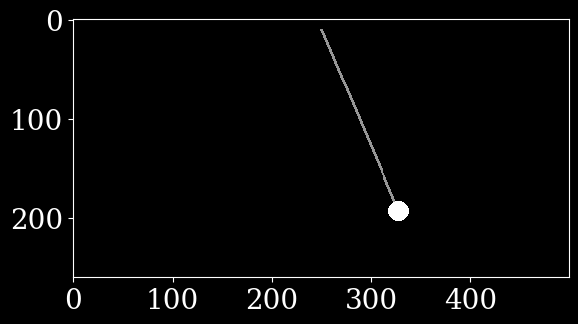

In [9]:
data_iter = iter(train_dataloader)

# Get a batch of data
batch_data = next(data_iter)

# Get the shape of the batch
batch_shape = batch_data[0][0].shape

print("Batch shape:", batch_shape)

testimage = batch_data[0][0][0]
cmap = plt.cm.get_cmap('Greys_r', 256)

# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
testimage = batch_data[0][0][10]
# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
testimage = batch_data[0][0][20]
# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')
testimage = batch_data[0][0][30]
# set gray colormap imshow
plt.figure()
plt.imshow(testimage.permute(1, 2, 0), cmap=cmap, interpolation='nearest')

#cp.plotMatrix(testimage.permute(1, 2, 0),'xlabel', 'ylabel','title', 'name', styleDark = True)

Image shape: (500, 500)
Tensor image shape: torch.Size([1, 500, 500])
Max value: tensor(1.)


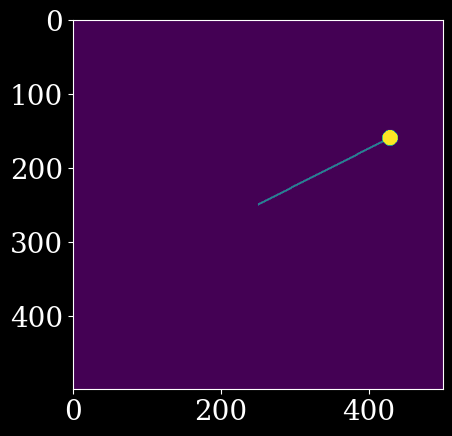

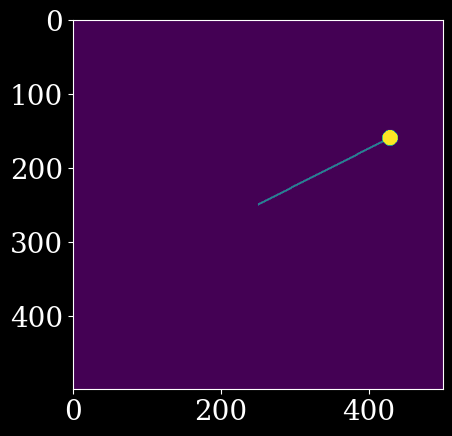

In [10]:
im1 = genData.create_pendulum_image(90)
print("Image shape:", im1.size)
plt.figure()
plt.imshow(im1)
from torchvision import transforms
convert_tensor = transforms.ToTensor()

tensor_image = convert_tensor(im1)
# Print tensor image shape
print("Tensor image shape:", tensor_image.shape)
# print max value torch tensor
print("Max value:", torch.max(tensor_image))
plt.figure()
plt.imshow(  tensor_image.permute(1, 2, 0)  )

# Models

Using device: cpu
epoch: 10 	 training loss: 0.09032488614320755 	 validation loss: 0.11749691888689995 	 accuracy : 1.0
epoch: 20 	 training loss: 0.08376769125461578 	 validation loss: 0.12286796048283577 	 accuracy : 1.0
epoch: 30 	 training loss: 0.08225342780351638 	 validation loss: 0.12458773329854012 	 accuracy : 1.0
epoch: 40 	 training loss: 0.08402919322252274 	 validation loss: 0.12198932841420174 	 accuracy : 1.0
epoch: 50 	 training loss: 0.08125761300325393 	 validation loss: 0.12202628701925278 	 accuracy : 1.0
epoch: 60 	 training loss: 0.0826525941491127 	 validation loss: 0.12136842682957649 	 accuracy : 1.0
epoch: 70 	 training loss: 0.08159133940935134 	 validation loss: 0.11992194876074791 	 accuracy : 1.0
epoch: 80 	 training loss: 0.0818904921412468 	 validation loss: 0.11976766958832741 	 accuracy : 1.0
epoch: 90 	 training loss: 0.08396656811237335 	 validation loss: 0.12023437395691872 	 accuracy : 1.0
epoch: 100 	 training loss: 0.0811483696103096 	 validati

<Figure size 640x480 with 0 Axes>

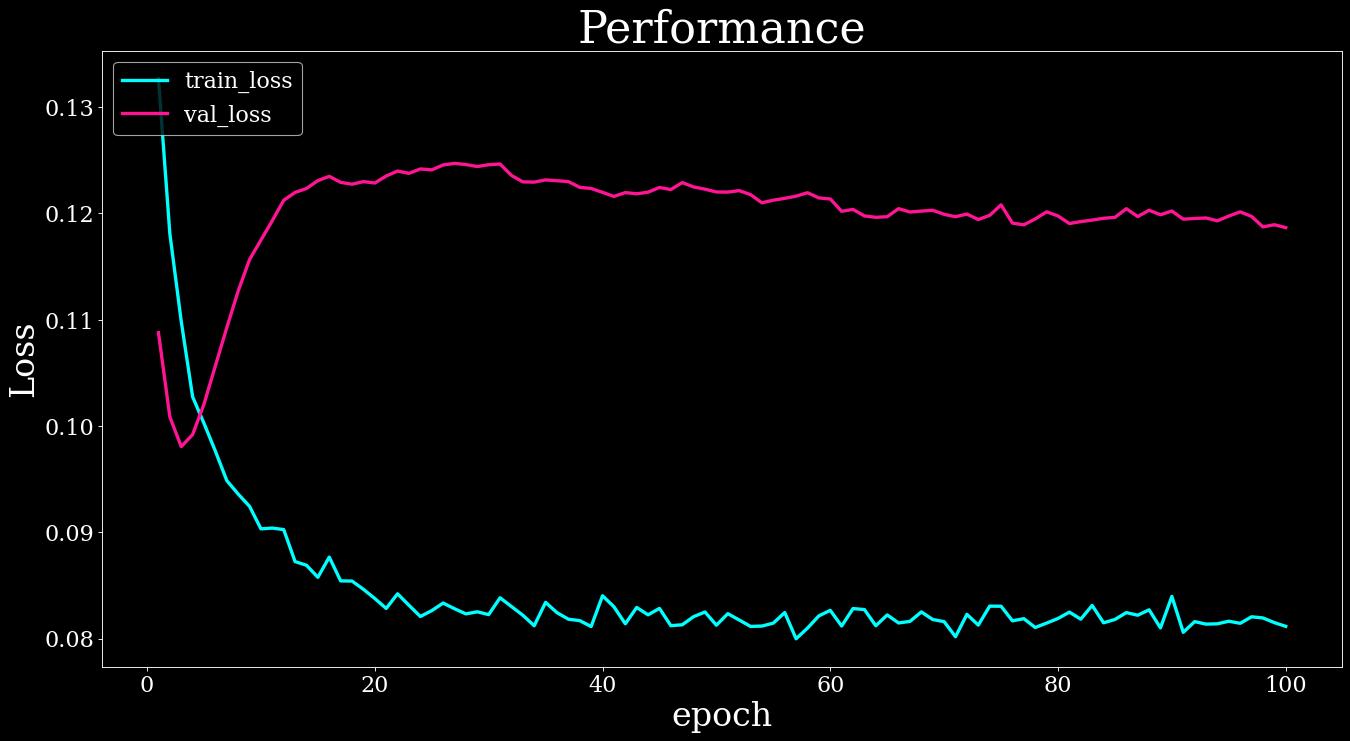

In [6]:

modelAE = models.AE(dt=1/30, initw=True)

modelAE, train_losses, val_losses, accuracy_list  = train.train(modelAE, train_dataloader, test_dataloader, 'GNNSimple')

In [1]:
visual_loader= loader.getLoader(a, split=False)

def visualize(model, loader, device='cpu'):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Create a video of the swinging pendulum
    video_name = 'pendulum_swing.mp4'
    frame_rate = 30
    duration = len(a) / frame_rate
    num_frames = frame_rate * duration

    # Initialize VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_name, fourcc, frame_rate, (500, 2*260))

    for data in loader:

        input_Data, out_Data = data

        x0,x1 = input_Data

        x0 = x0.to(device=device, dtype=torch.float)
        x1 = x1.to(device=device, dtype=torch.float)

        x2 = x2.to(device=device, dtype=torch.float)

        outputs = model(x0,x1)
        z,rec=outputs
        rec0,rec1,outrec=rec

        # Copy tensor and send to cpu and detach
        expec = x2.to('cpu').detach().numpy().copy()
        pred = outrec.to('cpu').detach().numpy().copy()

        # normalize to 0-1
        pred = (pred - pred.min()) / (pred.max() - pred.min())

        # concatenate expected and predicted one over the other
        expected_pred = np.concatenate((expec, pred), axis=0)

        #matrix to cv2 image
        expected_pred = np.uint8(expected_pred * 255)

        # Convert PIL image to OpenCV format
        cv2_frame = cv2.cvtColor(expected_pred, cv2.COLOR_RGB2BGR)
        
        # add text label
        cv2.putText(cv2_frame, 'Expected', (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
        cv2.putText(cv2_frame, 'Predicted', (10, 280), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA)

        
        # Add frame to the video
        video.write(cv2_frame)

    # Release the video writer
    video.release()


NameError: name 'loader' is not defined